In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import gc
import joblib
from collections import Counter
from tqdm import tqdm

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, roc_auc_score,
                           roc_curve, classification_report,
                           precision_recall_curve, average_precision_score)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, LayerNormalization,
                                   MultiHeadAttention, GlobalAveragePooling1D,
                                   Add, Concatenate, Masking)
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                                      ModelCheckpoint, TensorBoard)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)
tf.random.set_seed(42)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [3]:
df = pd.read_csv('Malware_dataset.csv')
df.head(10)

,hash,millisecond,classification,state,usage_counter,prio,static_prio,normal_prio,policy,vm_pgoff,vm_truncate_count,task_size,cached_hole_size,free_area_cache,mm_users,map_count,hiwater_rss,total_vm,shared_vm,exec_vm,reserved_vm,nr_ptes,end_data,last_interval,nvcsw,nivcsw,min_flt,maj_flt,fs_excl_counter,lock,utime,stime,gtime,cgtime,signal_nvcsw
0,42fb5e2ec009a05ff5143227297074f1e9c6c3ebb9c914e223349672eca79ad0,0,malware,0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0
1,42fb5e2ec009a05ff5143227297074f1e9c6c3ebb9c914e223349672eca79ad0,1,malware,0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0
2,42fb5e2ec009a05ff5143227297074f1e9c6c3ebb9c914e223349672eca79ad0,2,malware,0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0
3,42fb5e2ec009a05ff5143227297074f1e9c6c3ebb9c914e223349672eca79ad0,3,malware,0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0
4,42fb5e2ec009a05ff5143227297074f1e9c6c3ebb9c914e223349672eca79ad0,4,malware,0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0
5,42fb5e2ec009a05ff5143227297074f1e9c6c3ebb9c914e223349672eca79ad0,5,malware,0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0
6,42fb5e2ec009a05ff5143227297074f1e9c6c3ebb9c914e223349672eca79ad0,6,malware,0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0
7,42fb5e2ec009a05ff5143227297074f1e9c6c3ebb9c914e223349672eca79ad0,7,malware,0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0
8,42fb5e2ec009a05ff5143227297074f1e9c6c3ebb9c914e223349672eca79ad0,8,malware,0,0,3069378560,14274,0,0,0,13173,0,0,24,724,6850,0,150,120,124,210,0,120,3473,341974,0,0,120,0,3204448256,380690,4,0,0,0
9,42fb5e2ec009a05ff5143227297074f1e9c6c3ebb9c914e223349672eca79ad0,9,malware,0,0,3069378560,14274,0,0,0,13173,0,0,25,724,6852,0,150,120,124,211,0,120,3473,341974,0,130,120,0,3204448256,380690,4,0,0,0


In [4]:
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())

Dataset Shape: (100000, 35)

Column Names:
['hash', 'millisecond', 'classification', 'state', 'usage_counter', 'prio', 'static_prio', 'normal_prio', 'policy', 'vm_pgoff', 'vm_truncate_count', 'task_size', 'cached_hole_size', 'free_area_cache', 'mm_users', 'map_count', 'hiwater_rss', 'total_vm', 'shared_vm', 'exec_vm', 'reserved_vm', 'nr_ptes', 'end_data', 'last_interval', 'nvcsw', 'nivcsw', 'min_flt', 'maj_flt', 'fs_excl_counter', 'lock', 'utime', 'stime', 'gtime', 'cgtime', 'signal_nvcsw']


In [5]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 35 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   hash               100000 non-null  object
 1   millisecond        100000 non-null  int64 
 2   classification     100000 non-null  object
 3   state              100000 non-null  int64 
 4   usage_counter      100000 non-null  int64 
 5   prio               100000 non-null  int64 
 6   static_prio        100000 non-null  int64 
 7   normal_prio        100000 non-null  int64 
 8   policy             100000 non-null  int64 
 9   vm_pgoff           100000 non-null  int64 
 10  vm_truncate_count  100000 non-null  int64 
 11  task_size          100000 non-null  int64 
 12  cached_hole_size   100000 non-null  int64 
 13  free_area_cache    100000 non-null  int64 
 14  mm_users           100000 non-null  int64 
 15  map_count          100000 non-null  int64 
 16  hiwater_rss        10

,millisecond,state,usage_counter,prio,static_prio,normal_prio,policy,vm_pgoff,vm_truncate_count,task_size,cached_hole_size,free_area_cache,mm_users,map_count,hiwater_rss,total_vm,shared_vm,exec_vm,reserved_vm,nr_ptes,end_data,last_interval,nvcsw,nivcsw,min_flt,maj_flt,fs_excl_counter,lock,utime,stime,gtime,cgtime,signal_nvcsw
count,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000,100000.0000
mean,499.5000,157768.3354,0.0000,3069705994.2400,18183.9001,0.0000,0.0000,0.0000,15312.7395,0.0000,0.0000,9.5878,728.4654,8771.1395,0.0000,266.4911,117.9202,127.6782,205.3248,0.0000,117.9202,2435.9736,348313.0716,32.9912,2.0531,117.9202,1.1092,3204448256.0000,385415.4520,4.0593,1.6614,0.0000,0.0000
std,288.6764,936172.5833,0.0000,296306.1442,4609.7928,0.0000,0.0000,0.0000,3256.4750,0.0000,0.0000,46.5049,84.4754,3785.3052,0.0000,311.9968,3.1169,22.2780,112.7179,0.0000,3.1169,2605.5647,9117.7206,52.7302,13.8814,3.1169,2.1605,0.0000,10144.0365,0.8228,3.2630,0.0000,0.0000
min,0.0000,0.0000,0.0000,3069190144.0000,13988.0000,0.0000,0.0000,0.0000,9695.0000,0.0000,0.0000,0.0000,612.0000,2588.0000,0.0000,4.0000,112.0000,92.0000,29.0000,0.0000,112.0000,0.0000,337688.0000,0.0000,0.0000,112.0000,0.0000,3204448256.0000,371782.0000,3.0000,0.0000,0.0000,0.0000
25%,249.7500,0.0000,0.0000,3069446144.0000,14352.0000,0.0000,0.0000,0.0000,12648.0000,0.0000,0.0000,0.0000,651.0000,6428.0000,0.0000,99.0000,114.0000,112.0000,112.0000,0.0000,114.0000,0.0000,341974.0000,1.0000,0.0000,114.0000,0.0000,3204448256.0000,378208.0000,3.0000,0.0000,0.0000,0.0000
50%,499.5000,0.0000,0.0000,3069698048.0000,16159.0000,0.0000,0.0000,0.0000,15245.0000,0.0000,0.0000,1.0000,725.0000,7865.0000,0.0000,177.0000,120.0000,127.0000,193.0000,0.0000,120.0000,2017.0000,347244.0000,9.0000,1.0000,120.0000,0.0000,3204448256.0000,383637.0000,4.0000,0.0000,0.0000,0.0000
75%,749.2500,4096.0000,0.0000,3069957120.0000,22182.0000,0.0000,0.0000,0.0000,17663.0000,0.0000,0.0000,4.0000,785.0000,10684.0000,0.0000,327.0000,120.0000,138.0000,273.0000,0.0000,120.0000,4036.0000,351667.0000,46.0000,1.0000,120.0000,1.0000,3204448256.0000,390324.0000,5.0000,1.0000,0.0000,0.0000
max,999.0000,43266048.0000,0.0000,3070222336.0000,31855.0000,0.0000,0.0000,0.0000,27157.0000,0.0000,0.0000,515.0000,995.0000,28184.0000,0.0000,2810.0000,120.0000,196.0000,755.0000,0.0000,120.0000,9526.0000,384520.0000,365.0000,256.0000,120.0000,18.0000,3204448256.0000,421913.0000,7.0000,15.0000,0.0000,0.0000


In [6]:
df.isnull().sum()

,0
hash,0
millisecond,0
classification,0
state,0
usage_counter,0
prio,0
static_prio,0
normal_prio,0
policy,0
vm_pgoff,0


In [7]:
print("\nClass Distribution:")
print(df['classification'].value_counts())
print("\nClass Distribution (%):")
print(df['classification'].value_counts(normalize=True) * 100)


Class Distribution:
classification
malware    50000
benign     50000
Name: count, dtype: int64

Class Distribution (%):
classification
malware   50.0000
benign    50.0000
Name: proportion, dtype: float64


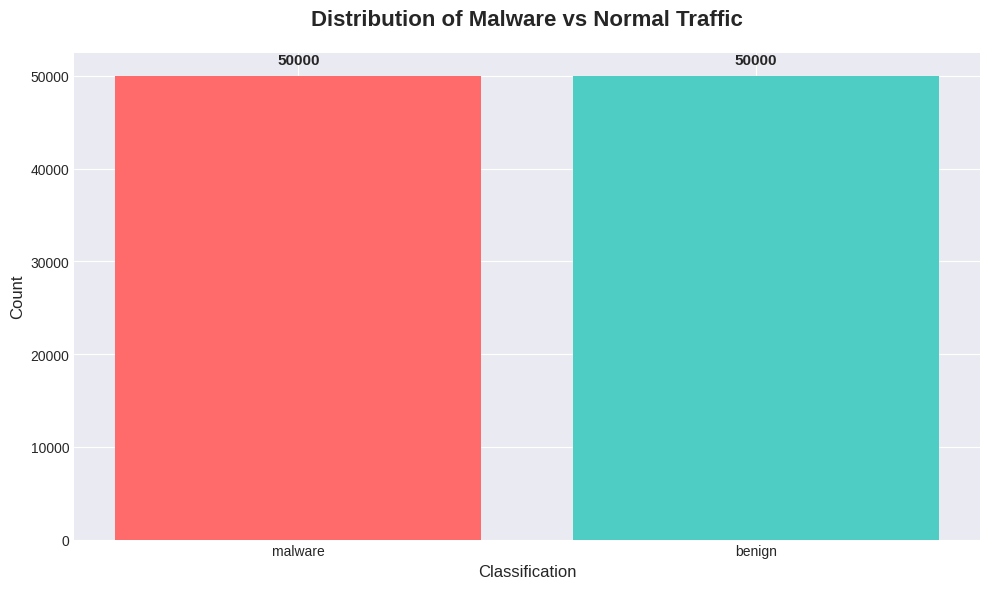

In [8]:
plt.figure(figsize=(10, 6))
class_counts = df['classification'].value_counts()
plt.bar(class_counts.index, class_counts.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.title('Distribution of Malware vs Normal Traffic', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Classification', fontsize=12)
plt.ylabel('Count', fontsize=12)
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 1000, str(v), ha='center', va='bottom', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

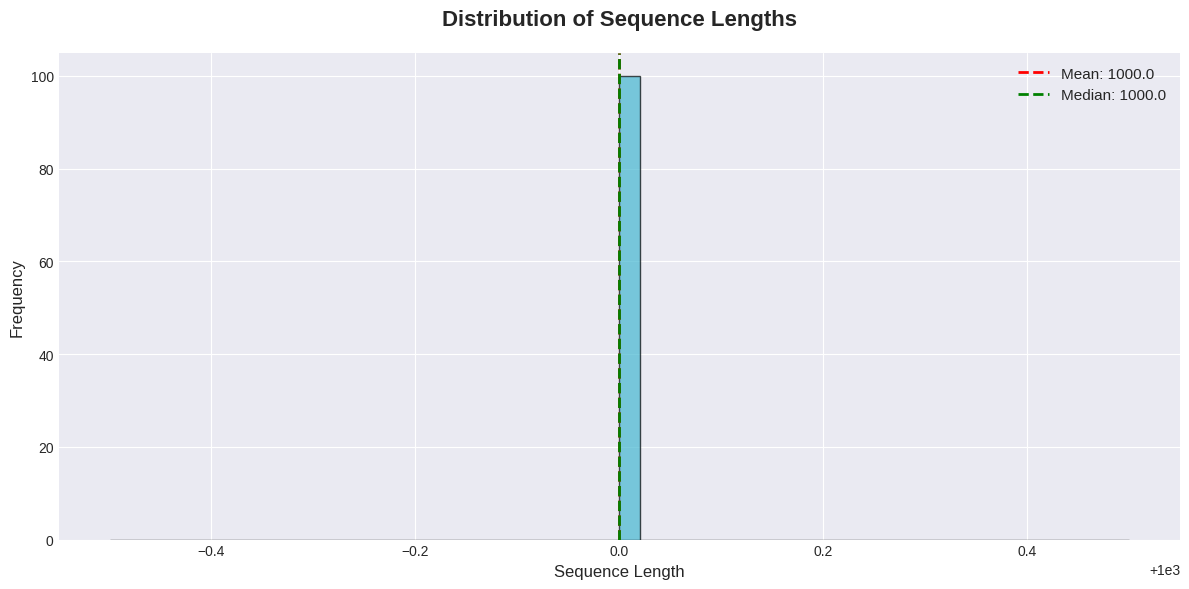

In [9]:
sequence_lengths = df.groupby('hash').size()

plt.figure(figsize=(12, 6))
plt.hist(sequence_lengths, bins=50, color='#45B7D1', edgecolor='black', alpha=0.7)
plt.title('Distribution of Sequence Lengths', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Sequence Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(sequence_lengths.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {sequence_lengths.mean():.1f}')
plt.axvline(sequence_lengths.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {sequence_lengths.median():.1f}')
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()


Number of features: 32


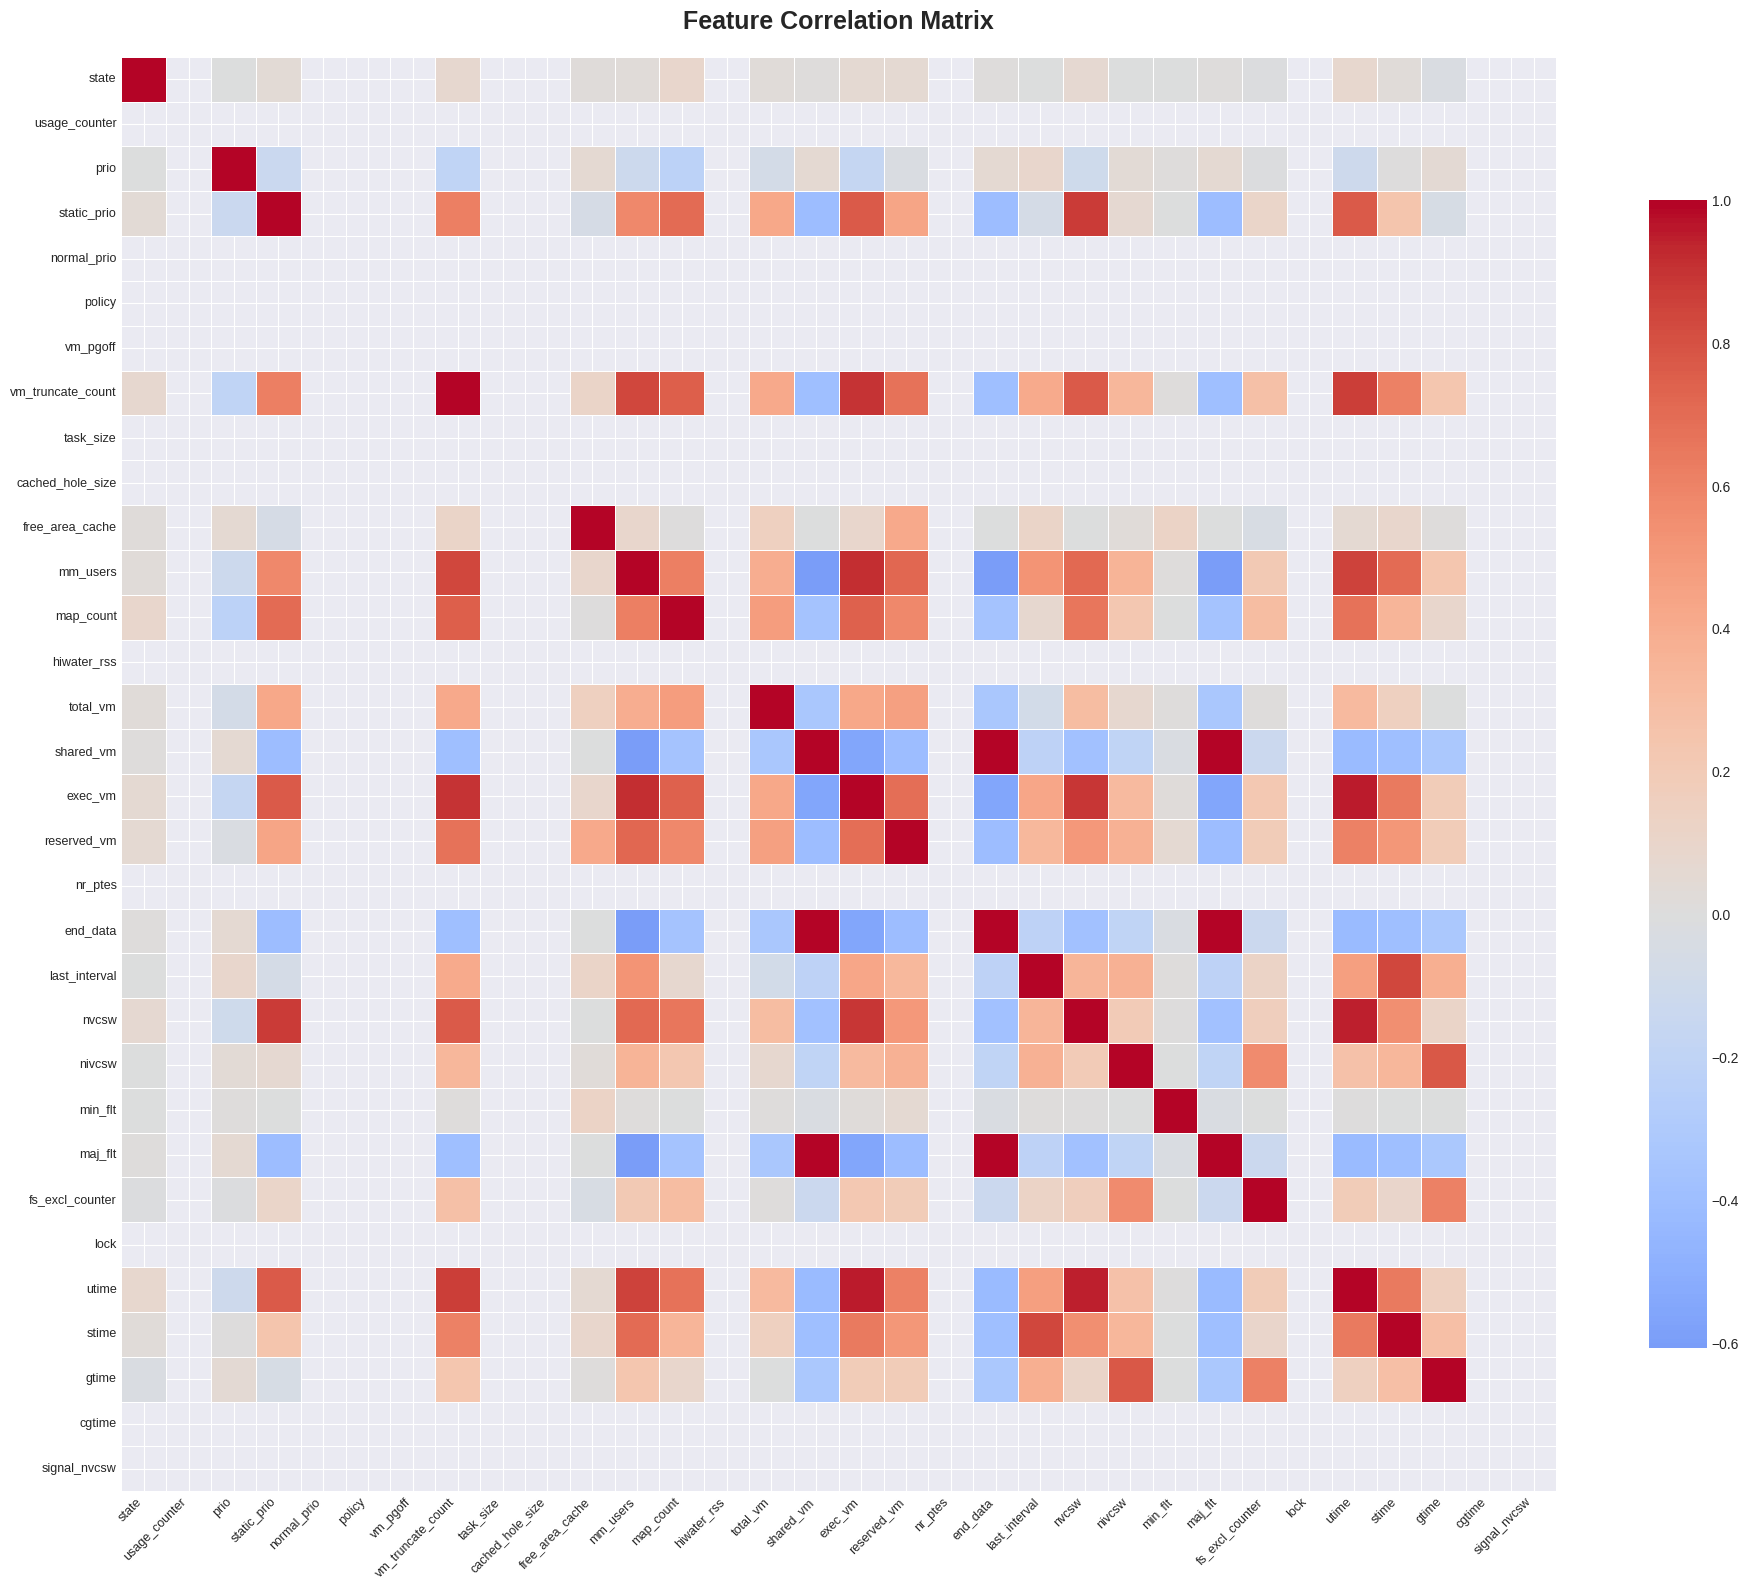

In [10]:
feature_cols = df.columns.drop(['hash', 'millisecond', 'classification'])
print(f"\nNumber of features: {len(feature_cols)}")

correlation_matrix = df[feature_cols].corr()

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=18, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()

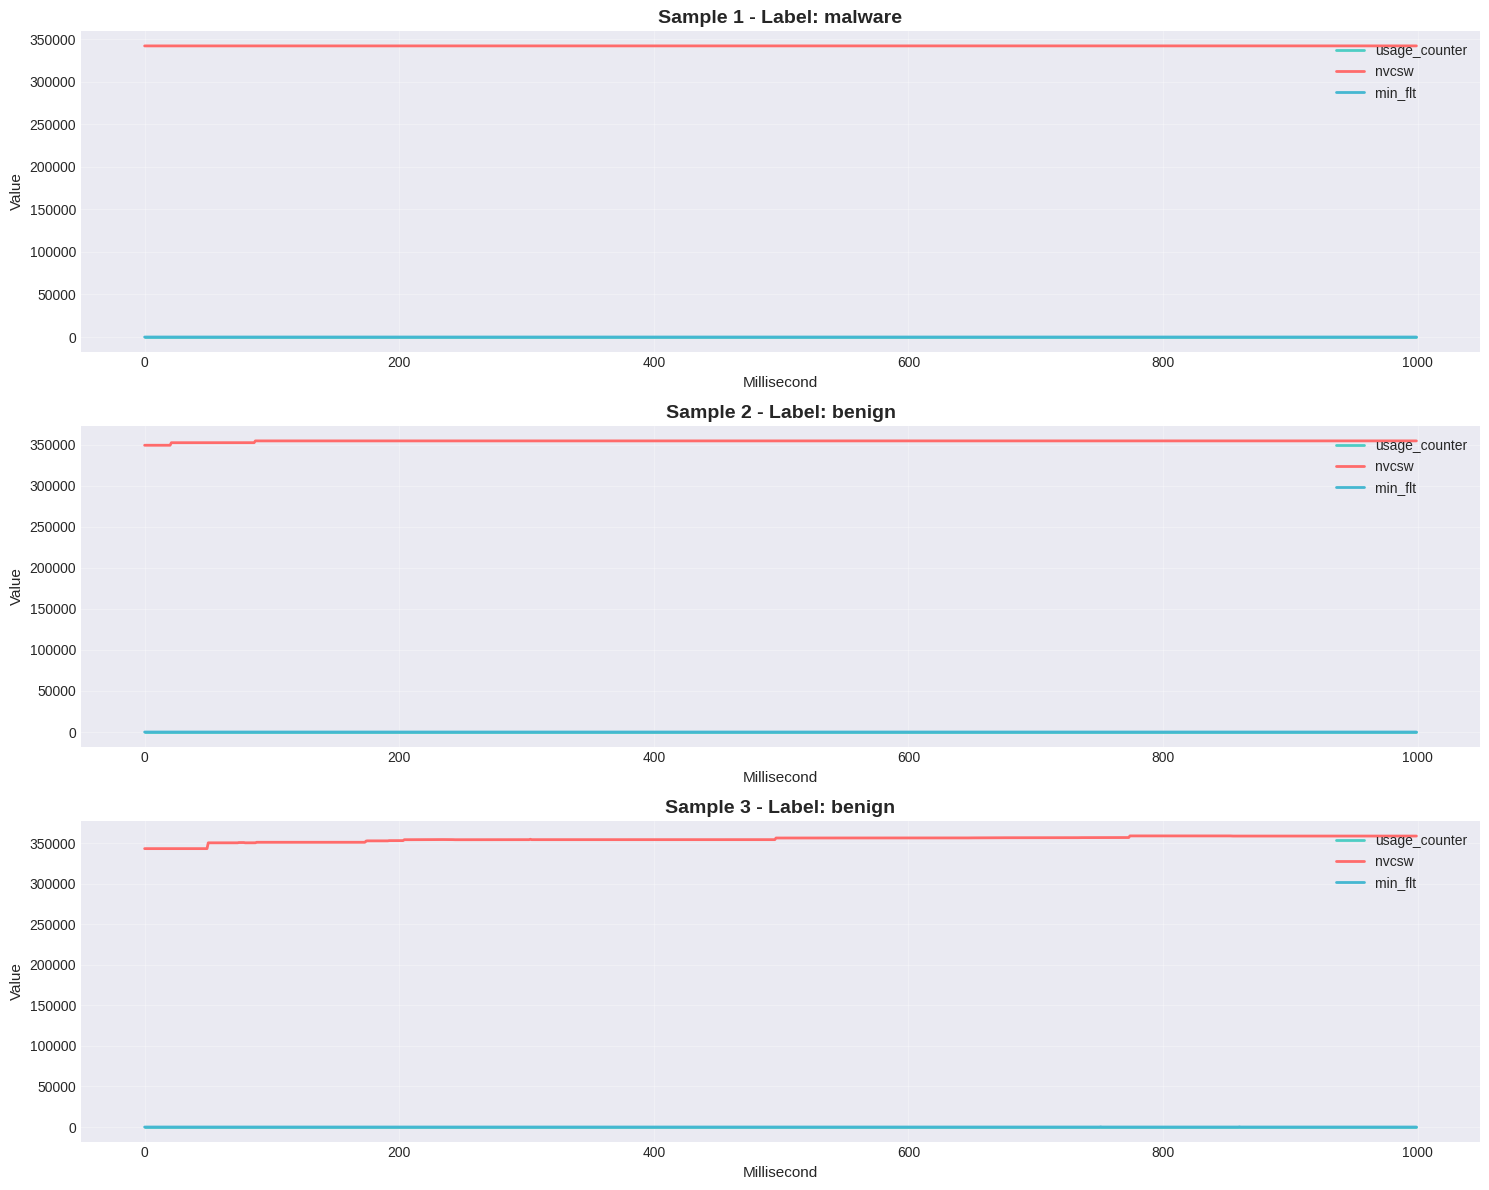

In [11]:
sample_hashes = df['hash'].unique()[:3]

plt.figure(figsize=(15, 12))

for idx, hash_id in enumerate(sample_hashes):
    sample_data = df[df['hash'] == hash_id].sort_values('millisecond')
    label = sample_data['classification'].iloc[0]

    plt.subplot(3, 1, idx + 1)

    plt.plot(sample_data['millisecond'], sample_data['usage_counter'],
             color='#4ECDC4', linewidth=2, label='usage_counter')

    plt.plot(sample_data['millisecond'], sample_data['nvcsw'],
             color='#FF6B6B', linewidth=2, label='nvcsw')

    plt.plot(sample_data['millisecond'], sample_data['min_flt'],
             color='#45B7D1', linewidth=2, label='min_flt')

    plt.title(f'Sample {idx+1} - Label: {label}', fontsize=14, fontweight='bold')
    plt.xlabel('Millisecond', fontsize=11)
    plt.ylabel('Value', fontsize=11)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
MAX_SEQUENCE_LENGTH = 50
FEATURE_COLUMNS = [col for col in df.columns if col not in ['hash', 'millisecond', 'classification']]
NUM_FEATURES = len(FEATURE_COLUMNS)

print(f"Maximum sequence length: {MAX_SEQUENCE_LENGTH}")
print(f"Number of features: {NUM_FEATURES}")

le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['classification'])

print("\nLabel encoding:")
for i, label in enumerate(le.classes_):
    print(f"  {label}: {i}")


Maximum sequence length: 50
Number of features: 32

Label encoding:
  benign: 0
  malware: 1


In [13]:
sequences = []
labels = []
hash_ids = []

for hash_id in tqdm(df['hash'].unique(), desc="Creating sequences"):
    hash_data = df[df['hash'] == hash_id].sort_values('millisecond')

    sequence = hash_data[FEATURE_COLUMNS].values
    label = hash_data['label_encoded'].iloc[0]

    if len(sequence) < 10:
        continue

    if len(sequence) > MAX_SEQUENCE_LENGTH:
        for i in range(0, len(sequence) - MAX_SEQUENCE_LENGTH + 1, MAX_SEQUENCE_LENGTH // 2):
            sub_seq = sequence[i:i + MAX_SEQUENCE_LENGTH]
            if len(sub_seq) == MAX_SEQUENCE_LENGTH:
                sequences.append(sub_seq)
                labels.append(label)
                hash_ids.append(hash_id)
    else:
        padding = np.zeros((MAX_SEQUENCE_LENGTH - len(sequence), NUM_FEATURES))
        padded_sequence = np.vstack([sequence, padding])
        sequences.append(padded_sequence)
        labels.append(label)
        hash_ids.append(hash_id)

X = np.array(sequences)
y = np.array(labels)

print(f"\nSequences shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"\nLabel distribution:")
unique, counts = np.unique(y, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  {le.inverse_transform([u])[0]}: {c} ({c/len(y)*100:.2f}%)")


Creating sequences: 100%|██████████| 100/100 [00:00<00:00, 110.81it/s]


Sequences shape: (3900, 50, 32)
Labels shape: (3900,)

Label distribution:
  benign: 1950 (50.00%)
  malware: 1950 (50.00%)


In [14]:
X_reshaped = X.reshape(-1, NUM_FEATURES)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_reshaped)
X_normalized = X_normalized.reshape(X.shape)

print(f"Normalized data shape: {X_normalized.shape}")

Normalized data shape: (3900, 50, 32)


In [15]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X_normalized, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
)

print(f"\nDataset splits:")
print(f"Train set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

print("\nClass distribution:")
for split_name, split_y in [('Train', y_train), ('Val', y_val), ('Test', y_test)]:
    unique, counts = np.unique(split_y, return_counts=True)
    print(f"{split_name:5s} - ", end="")
    for u, c in zip(unique, counts):
        print(f"{le.inverse_transform([u])[0]}: {c:4d} ({c/len(split_y)*100:5.2f}%)  ", end="")
    print()


Dataset splits:
Train set: 2731 samples
Validation set: 584 samples
Test set: 585 samples

Class distribution:
Train - benign: 1365 (49.98%)  malware: 1366 (50.02%)  
Val   - benign:  292 (50.00%)  malware:  292 (50.00%)  
Test  - benign:  293 (50.09%)  malware:  292 (49.91%)  


In [16]:
def f1_metric(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred_binary = K.round(K.clip(y_pred, 0, 1))

    tp = K.sum(y_true * y_pred_binary)
    fp = K.sum((1 - y_true) * y_pred_binary)
    fn = K.sum(y_true * (1 - y_pred_binary))

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return f1

def balanced_accuracy(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred_binary = K.round(K.clip(y_pred, 0, 1))

    tp = K.sum(y_true * y_pred_binary)
    tn = K.sum((1 - y_true) * (1 - y_pred_binary))
    fp = K.sum((1 - y_true) * y_pred_binary)
    fn = K.sum(y_true * (1 - y_pred_binary))

    sensitivity = tp / (tp + fn + K.epsilon())
    specificity = tn / (tn + fp + K.epsilon())

    return (sensitivity + specificity) / 2.0

In [17]:
class TransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate

        self.att = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim,
            dropout=dropout_rate
        )
        self.ffn = keras.Sequential([
            Dense(ff_dim, activation='relu', kernel_regularizer=l2(0.01)),
            Dropout(dropout_rate),
            Dense(embed_dim, kernel_regularizer=l2(0.01))
        ])

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1, training=training)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

    def get_config(self):
        config = super().get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'dropout_rate': self.dropout_rate
        })
        return config

In [18]:
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, max_len, embed_dim, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.max_len = max_len
        self.embed_dim = embed_dim
        self.pos_encoding = self.create_positional_encoding()

    def create_positional_encoding(self):
        position = np.arange(self.max_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, self.embed_dim, 2) * -(np.log(10000.0) / self.embed_dim))

        pos_encoding = np.zeros((self.max_len, self.embed_dim))
        pos_encoding[:, 0::2] = np.sin(position * div_term)
        pos_encoding[:, 1::2] = np.cos(position * div_term)

        return tf.cast(pos_encoding[np.newaxis, ...], dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

    def get_config(self):
        config = super().get_config()
        config.update({
            'max_len': self.max_len,
            'embed_dim': self.embed_dim
        })
        return config

In [19]:
def build_malware_transformer_model(
    sequence_length,
    num_features,
    embed_dim=64,
    num_heads=4,
    ff_dim=128,
    num_transformer_blocks=2,
    dropout_rate=0.4
):
    inputs = Input(shape=(sequence_length, num_features))

    x = Masking(mask_value=0.0)(inputs)

    x = Dense(embed_dim, activation='relu', kernel_regularizer=l2(0.02))(x)
    x = Dropout(dropout_rate)(x)

    x = PositionalEncoding(sequence_length, embed_dim)(x)

    for _ in range(num_transformer_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate)(x)

    x = GlobalAveragePooling1D()(x)

    x = Dense(128, activation='relu', kernel_regularizer=l2(0.02))(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.02))(x)
    x = Dropout(dropout_rate)(x)

    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model

model = build_malware_transformer_model(
    sequence_length=MAX_SEQUENCE_LENGTH,
    num_features=NUM_FEATURES,
    embed_dim=64,
    num_heads=4,
    ff_dim=128,
    num_transformer_blocks=2,
    dropout_rate=0.4
)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masking (Masking)               │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50, 64)         │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding             │ (None, 50, 64)         │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 50, 64)         │        83,200 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 50, 64)         │        83,200 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,153 (723.25 KB)

 Trainable params: 185,153 (723.25 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             f1_metric,
             balanced_accuracy]
)

In [21]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        'malware_transformer_best_model.keras',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )
]

In [22]:
EPOCHS = 100
BATCH_SIZE = 64

class_weight = {
    0: len(y_train) / (2 * np.sum(y_train == 0)),
    1: len(y_train) / (2 * np.sum(y_train == 1))
}

print(f"\nClass weights: {class_weight}")

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)


Class weights: {0: np.float64(1.0003663003663004), 1: np.float64(0.9996339677891655)}
Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.6296 - balanced_accuracy: 0.5000 - f1_metric: 0.4798 - loss: 7.3509 - precision: 0.6292 - recall: 0.6338
Epoch 1: val_accuracy improved from -inf to 0.91610, saving model to malware_transformer_best_model.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 34s 360ms/step - accuracy: 0.6323 - balanced_accuracy: 0.5000 - f1_metric: 0.4799 - loss: 7.3289 - precision: 0.6320 - recall: 0.6362 - val_accuracy: 0.9161 - val_balanced_accuracy: 0.5000 - val_f1_metric: 0.4817 - val_loss: 4.4864 - val_precision: 0.9091 - val_recall: 0.9247 - learning_rate: 0.0010
Epoch 2/100
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9151 - balanced_accuracy: 0.5000 - f1_metric: 0.4888 - loss: 4.0019 - precision: 0.9264 - recall: 0.9009
Epoch 2: val_accuracy improved from 0.91610 to 0.95890, saving model to malware_transformer_best_model.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 1

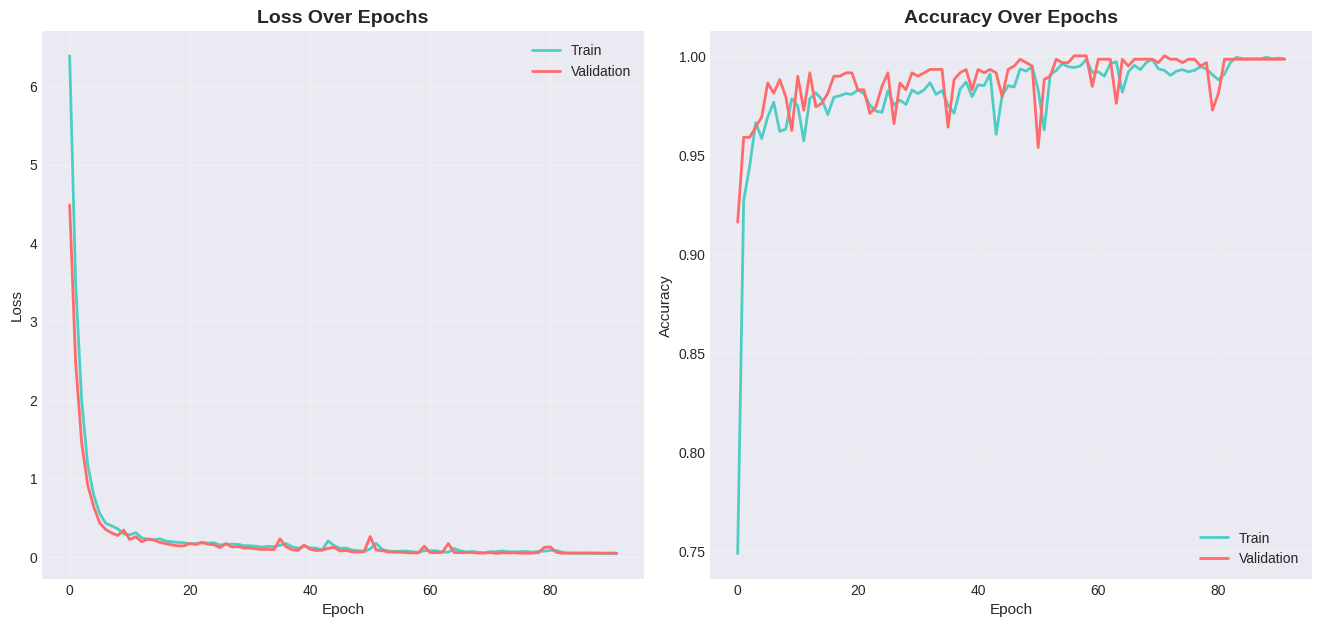

In [23]:
metrics = [
    ('loss', 'Loss'),
    ('accuracy', 'Accuracy'),
]

plt.figure(figsize=(20, 12))

for idx, (metric, title) in enumerate(metrics):
    plt.subplot(2, 3, idx + 1)

    plt.plot(history.history[metric], label='Train', linewidth=2, color='#4ECDC4')
    plt.plot(history.history[f'val_{metric}'], label='Validation', linewidth=2, color='#FF6B6B')

    plt.title(f'{title} Over Epochs', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=11)
    plt.ylabel(title, fontsize=11)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [24]:
val_predictions_proba = model.predict(X_val, batch_size=BATCH_SIZE, verbose=0)
val_predictions = (val_predictions_proba >= 0.5).astype(int).flatten()

val_cm = confusion_matrix(y_val, val_predictions)
tn, fp, fn, tp = val_cm.ravel()

val_metrics = {
    'accuracy': accuracy_score(y_val, val_predictions),
    'precision': precision_score(y_val, val_predictions, zero_division=0),
    'recall': recall_score(y_val, val_predictions, zero_division=0),
    'f1_score': f1_score(y_val, val_predictions, zero_division=0),
    'roc_auc': roc_auc_score(y_val, val_predictions_proba),
    'sensitivity': tp / (tp + fn) if (tp + fn) > 0 else 0,
    'specificity': tn / (tn + fp) if (tn + fp) > 0 else 0
}
val_metrics['balanced_accuracy'] = (val_metrics['sensitivity'] + val_metrics['specificity']) / 2

print("\nValidation Set Performance:")
for metric_name, metric_value in val_metrics.items():
    print(f"  {metric_name.replace('_', ' ').title()}: {metric_value:.4f}")

print(f"\nValidation Confusion Matrix:\n{val_cm}")



Validation Set Performance:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
  Roc Auc: 1.0000
  Sensitivity: 1.0000
  Specificity: 1.0000
  Balanced Accuracy: 1.0000

Validation Confusion Matrix:
[[292   0]
 [  0 292]]


In [25]:
test_predictions_proba = model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
test_predictions = (test_predictions_proba >= 0.5).astype(int).flatten()

test_cm = confusion_matrix(y_test, test_predictions)
tn, fp, fn, tp = test_cm.ravel()

test_metrics = {
    'accuracy': accuracy_score(y_test, test_predictions),
    'precision': precision_score(y_test, test_predictions, zero_division=0),
    'recall': recall_score(y_test, test_predictions, zero_division=0),
    'f1_score': f1_score(y_test, test_predictions, zero_division=0),
    'roc_auc': roc_auc_score(y_test, test_predictions_proba),
    'sensitivity': tp / (tp + fn) if (tp + fn) > 0 else 0,
    'specificity': tn / (tn + fp) if (tn + fp) > 0 else 0
}
test_metrics['balanced_accuracy'] = (test_metrics['sensitivity'] + test_metrics['specificity']) / 2

print("\nTest Set Performance:")
for metric_name, metric_value in test_metrics.items():
    print(f"  {metric_name.replace('_', ' ').title()}: {metric_value:.4f}")

print(f"\nTest Confusion Matrix:\n{test_cm}")
print(f"\nBreakdown:")
print(f"  True Negatives:  {tn}")
print(f"  False Positives: {fp}")
print(f"  False Negatives: {fn}")
print(f"  True Positives:  {tp}")



Test Set Performance:
  Accuracy: 0.9915
  Precision: 0.9864
  Recall: 0.9966
  F1 Score: 0.9915
  Roc Auc: 0.9999
  Sensitivity: 0.9966
  Specificity: 0.9863
  Balanced Accuracy: 0.9915

Test Confusion Matrix:
[[289   4]
 [  1 291]]

Breakdown:
  True Negatives:  289
  False Positives: 4
  False Negatives: 1
  True Positives:  291


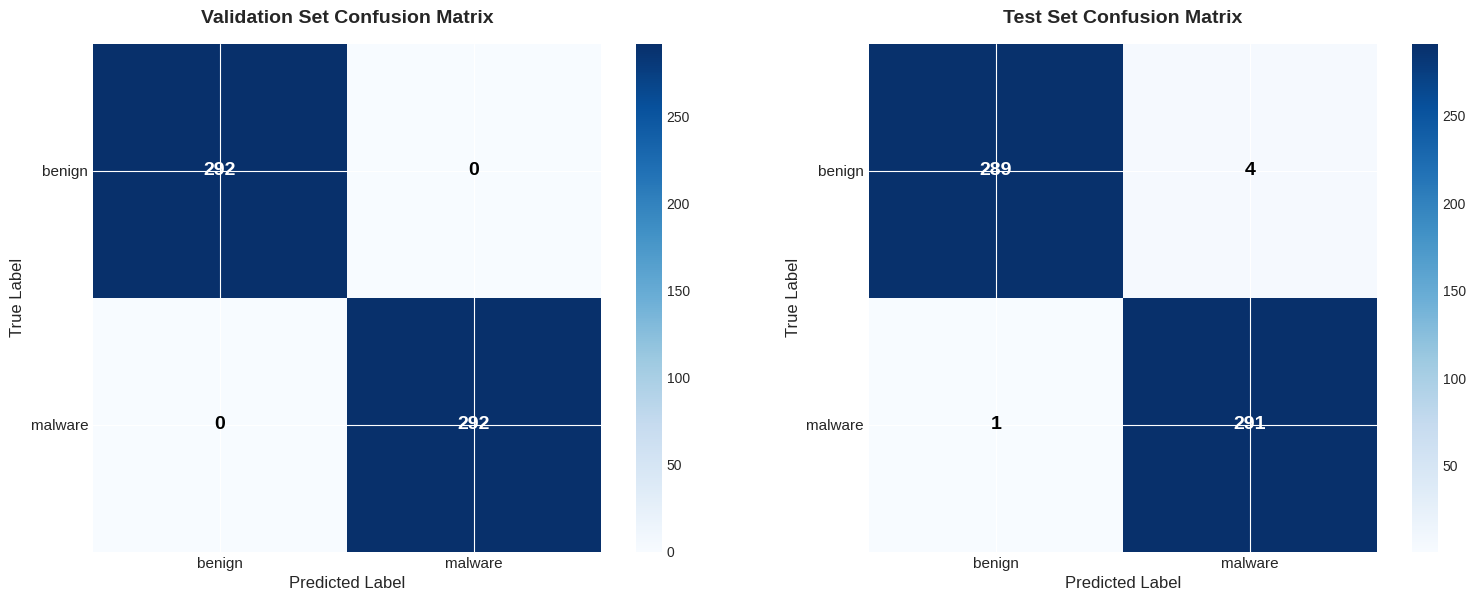

In [26]:
cm_list = [val_cm, test_cm]
titles = ['Validation Set Confusion Matrix', 'Test Set Confusion Matrix']

plt.figure(figsize=(16, 6))

for idx, (cm, title) in enumerate(zip(cm_list, titles)):
    plt.subplot(1, 2, idx + 1)

    im = plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(title, fontsize=14, fontweight='bold', pad=15)

    tick_marks = np.arange(len(le.classes_))
    plt.xticks(tick_marks, le.classes_, fontsize=11)
    plt.yticks(tick_marks, le.classes_, fontsize=11)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black",
                     fontsize=14, fontweight='bold')

    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.colorbar(im)

plt.tight_layout()
plt.show()

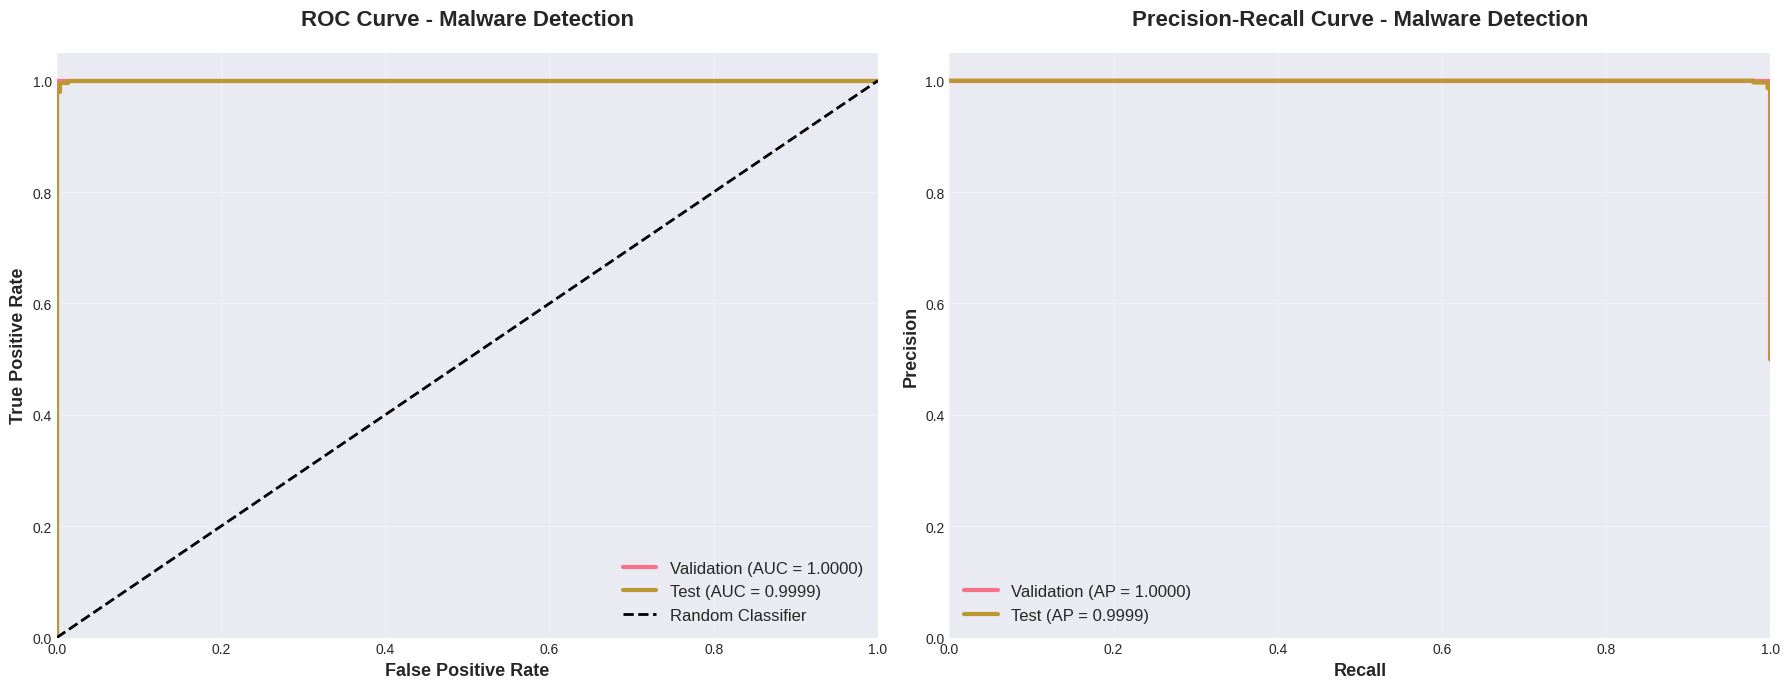

In [27]:
val_fpr, val_tpr, _ = roc_curve(y_val, val_predictions_proba)
test_fpr, test_tpr, _ = roc_curve(y_test, test_predictions_proba)

val_precision, val_recall, _ = precision_recall_curve(y_val, val_predictions_proba)
test_precision, test_recall, _ = precision_recall_curve(y_test, test_predictions_proba)

val_avg_precision = average_precision_score(y_val, val_predictions_proba)
test_avg_precision = average_precision_score(y_test, test_predictions_proba)

plt.figure(figsize=(18, 7))

plt.subplot(1, 2, 1)
plt.plot(val_fpr, val_tpr, linewidth=3, label=f'Validation (AUC = {val_metrics["roc_auc"]:.4f})')
plt.plot(test_fpr, test_tpr, linewidth=3, label=f'Test (AUC = {test_metrics["roc_auc"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
plt.title('ROC Curve - Malware Detection', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(val_recall, val_precision, linewidth=3, label=f'Validation (AP = {val_avg_precision:.4f})')
plt.plot(test_recall, test_precision, linewidth=3, label=f'Test (AP = {test_avg_precision:.4f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=13, fontweight='bold')
plt.ylabel('Precision', fontsize=13, fontweight='bold')
plt.title('Precision-Recall Curve - Malware Detection', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc="lower left", fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [28]:
print("\nDetailed Classification Report: ")
print(classification_report(y_test, test_predictions, target_names=le.classes_, digits=4))


Detailed Classification Report: 
              precision    recall  f1-score   support

      benign     0.9966    0.9863    0.9914       293
     malware     0.9864    0.9966    0.9915       292

    accuracy                         0.9915       585
   macro avg     0.9915    0.9915    0.9915       585
weighted avg     0.9915    0.9915    0.9915       585



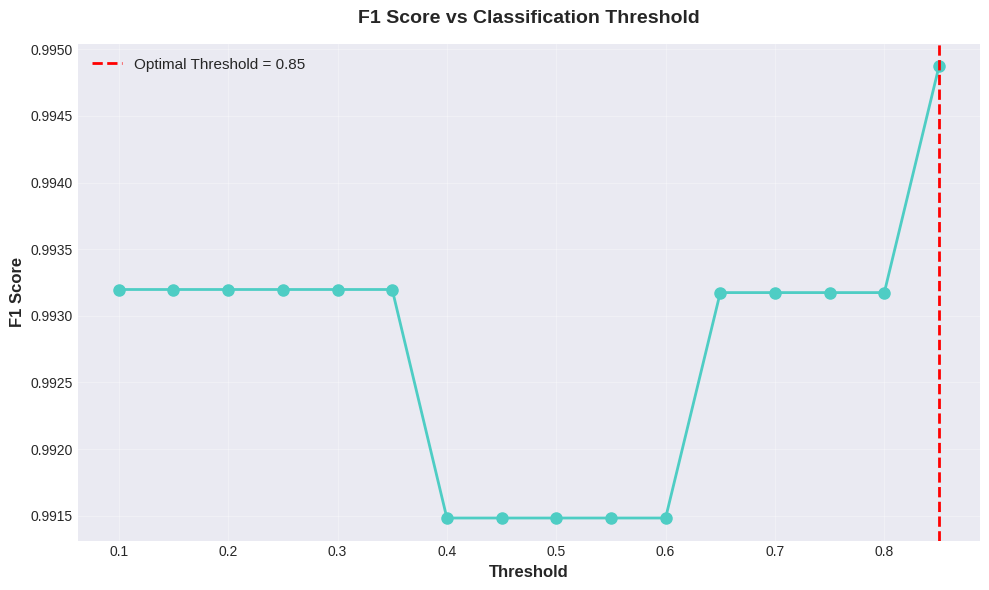

In [29]:
thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores = []

for thresh in thresholds:
    preds = (test_predictions_proba >= thresh).astype(int).flatten()
    f1 = f1_score(y_test, preds, zero_division=0)
    f1_scores.append(f1)

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, marker='o', linewidth=2, markersize=8, color='#4ECDC4')
plt.axvline(optimal_threshold, color='red', linestyle='--', linewidth=2,
            label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.xlabel('Threshold', fontsize=12, fontweight='bold')
plt.ylabel('F1 Score', fontsize=12, fontweight='bold')
plt.title('F1 Score vs Classification Threshold', fontsize=14, fontweight='bold', pad=15)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


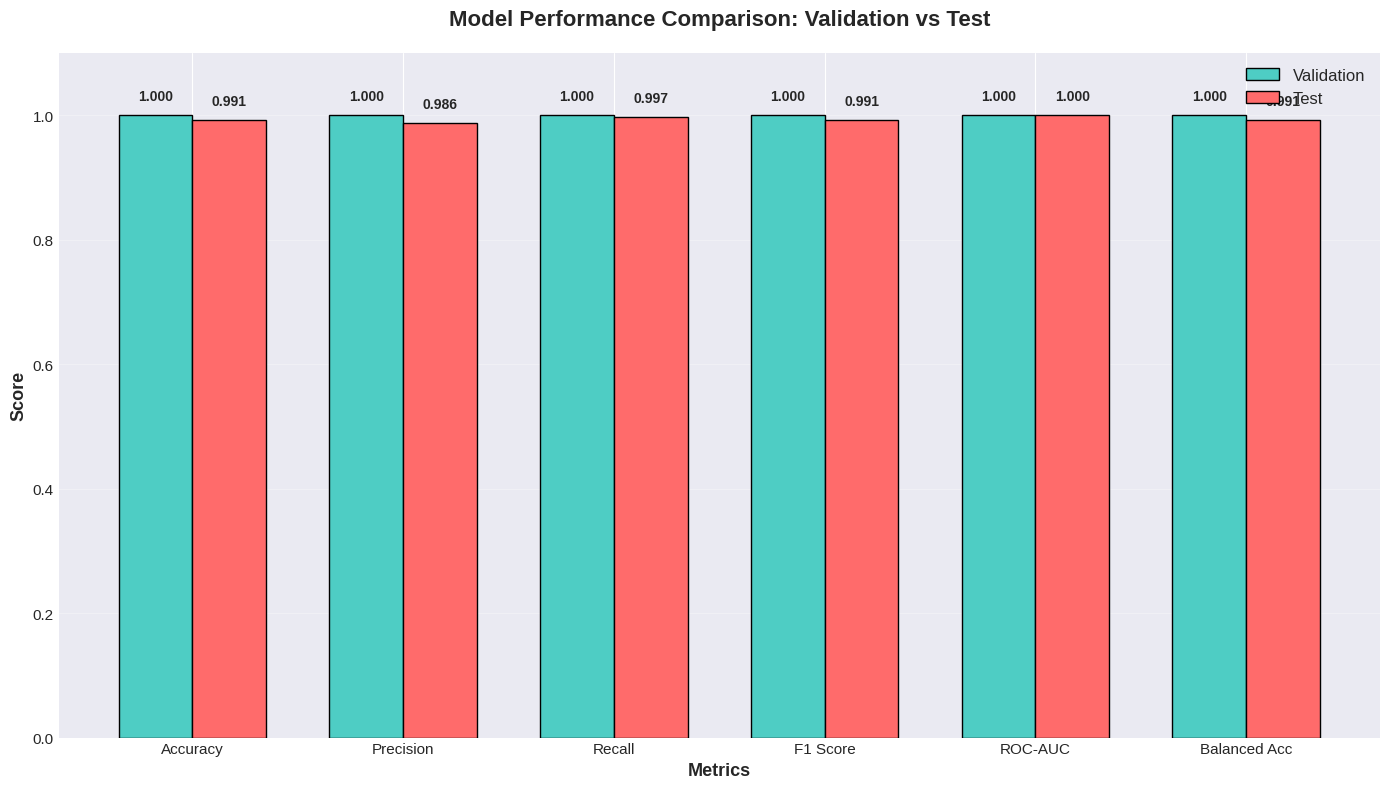

In [30]:
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC', 'Balanced Acc']
val_scores = [val_metrics['accuracy'], val_metrics['precision'], val_metrics['recall'],
              val_metrics['f1_score'], val_metrics['roc_auc'], val_metrics['balanced_accuracy']]
test_scores = [test_metrics['accuracy'], test_metrics['precision'], test_metrics['recall'],
               test_metrics['f1_score'], test_metrics['roc_auc'], test_metrics['balanced_accuracy']]

x = np.arange(len(metrics_names))
width = 0.35

plt.figure(figsize=(14, 8))
plt.bar(x - width/2, val_scores, width, label='Validation', color='#4ECDC4', edgecolor='black')
plt.bar(x + width/2, test_scores, width, label='Test', color='#FF6B6B', edgecolor='black')

plt.xlabel('Metrics', fontsize=13, fontweight='bold')
plt.ylabel('Score', fontsize=13, fontweight='bold')
plt.title('Model Performance Comparison: Validation vs Test', fontsize=16, fontweight='bold', pad=20)
plt.xticks(x, metrics_names, fontsize=11)
plt.yticks(fontsize=11)
plt.ylim([0, 1.1])
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3, axis='y')

for i, v in enumerate(val_scores):
    plt.text(i - width/2, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
for i, v in enumerate(test_scores):
    plt.text(i + width/2, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

In [31]:
model.save('malware_transformer_model.keras')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le, 'label_encoder.pkl')

evaluation_results = {
    'validation_metrics': val_metrics,
    'test_metrics': test_metrics,
    'validation_cm': val_cm,
    'test_cm': test_cm,
    'history': history.history,
    'optimal_threshold': optimal_threshold
}
joblib.dump(evaluation_results, 'evaluation_results.pkl')

preprocessing_config = {
    'max_sequence_length': MAX_SEQUENCE_LENGTH,
    'num_features': NUM_FEATURES,
    'feature_columns': FEATURE_COLUMNS,
    'optimal_threshold': optimal_threshold
}
joblib.dump(preprocessing_config, 'preprocessing_config.pkl')

print("\nBerhasil Disimpan")


Berhasil Disimpan


In [32]:
def predict_malware(data, model_path='malware_transformer_model.keras',
                   scaler_path='scaler.pkl', le_path='label_encoder.pkl',
                   config_path='preprocessing_config.pkl'):

    model = tf.keras.models.load_model(model_path, custom_objects={
        'TransformerBlock': TransformerBlock,
        'PositionalEncoding': PositionalEncoding,
        'f1_metric': f1_metric,
        'balanced_accuracy': balanced_accuracy
    })

    scaler = joblib.load(scaler_path)
    le = joblib.load(le_path)
    config = joblib.load(config_path)

    if isinstance(data, pd.DataFrame):
        sequences = []
        labels_list = []

        for hash_id in data['hash'].unique():
            hash_data = data[data['hash'] == hash_id].sort_values('millisecond')
            sequence = hash_data[config['feature_columns']].values

            if len(sequence) > config['max_sequence_length']:
                sequence = sequence[:config['max_sequence_length']]
            else:
                padding = np.zeros((config['max_sequence_length'] - len(sequence), config['num_features']))
                sequence = np.vstack([sequence, padding])

            sequences.append(sequence)
            labels_list.append(hash_id)

        X = np.array(sequences)
        X_reshaped = X.reshape(-1, config['num_features'])
        X_normalized = scaler.transform(X_reshaped)
        X_normalized = X_normalized.reshape(X.shape)

    else:
        X_normalized = data
        labels_list = [f"Sample_{i}" for i in range(len(data))]

    probabilities = model.predict(X_normalized, verbose=0).flatten()
    predictions = (probabilities >= config['optimal_threshold']).astype(int)

    results = []
    for i, label in enumerate(labels_list):
        results.append({
            'hash': label if isinstance(data, pd.DataFrame) else f"Sample_{i}",
            'prediction': le.inverse_transform([predictions[i]])[0],
            'probability': float(probabilities[i]),
            'confidence': float(probabilities[i]) if predictions[i] == 1 else float(1 - probabilities[i])
        })

    return results


In [33]:
sample_indices = np.random.choice(len(X_test), size=50, replace=False)
sample_sequences = X_test[sample_indices]
sample_labels = y_test[sample_indices]

predictions = predict_malware(sample_sequences)

print("\nPrediction Results:")
for i, pred in enumerate(predictions):
    true_label = le.inverse_transform([sample_labels[i]])[0]
    print(f"\nSample {i+1}:")
    print(f"  True Label:  {true_label}")
    print(f"  Prediction:  {pred['prediction']}")
    print(f"  Probability: {pred['probability']:.4f}")
    print(f"  Confidence:  {pred['confidence']:.4f}")


Prediction Results:

Sample 1:
  True Label:  benign
  Prediction:  benign
  Probability: 0.0004
  Confidence:  0.9996

Sample 2:
  True Label:  malware
  Prediction:  malware
  Probability: 0.9998
  Confidence:  0.9998

Sample 3:
  True Label:  benign
  Prediction:  benign
  Probability: 0.0004
  Confidence:  0.9996

Sample 4:
  True Label:  benign
  Prediction:  benign
  Probability: 0.0004
  Confidence:  0.9996

Sample 5:
  True Label:  benign
  Prediction:  benign
  Probability: 0.0006
  Confidence:  0.9994

Sample 6:
  True Label:  malware
  Prediction:  malware
  Probability: 0.9998
  Confidence:  0.9998

Sample 7:
  True Label:  benign
  Prediction:  benign
  Probability: 0.0004
  Confidence:  0.9996

Sample 8:
  True Label:  benign
  Prediction:  benign
  Probability: 0.0004
  Confidence:  0.9996

Sample 9:
  True Label:  malware
  Prediction:  malware
  Probability: 0.9998
  Confidence:  0.9998

Sample 10:
  True Label:  benign
  Prediction:  benign
  Probability: 0.0004
  Co